In [15]:

from google.api_core.client_options import ClientOptions
from google.cloud import documentai  # type: ignore

def ocr(
    project_id: str,
    location: str,
    processor_id: str,
    image_content: bytes,
    mime_type: str,
):
    # You must set the `api_endpoint`if you use a location other than "us".
    opts = ClientOptions(api_endpoint=f"{location}-documentai.googleapis.com")

    client = documentai.DocumentProcessorServiceClient(client_options=opts)

    # Load binary data
    raw_document = documentai.RawDocument(content=image_content, mime_type=mime_type)

    # Configure the process request
    # `processor.name` is the full resource name of the processor, e.g.:
    processor = f"projects/{project_id}/locations/{location}/processors/{processor_id}"
    request = documentai.ProcessRequest(name=processor, raw_document=raw_document)

    result = client.process_document(request=request)

    # For a full list of `Document` object attributes, reference this page:
    # https://cloud.google.com/document-ai/docs/reference/rest/v1/Document
    document = result.document

    return document.text.replace("\n", " ")

In [20]:
from datasets import load_dataset
from tqdm.auto import tqdm
from loguru import logger
import json
import io

dataset = load_dataset("naver-clova-ix/cord-v2", split="train")

for i, sample in tqdm(enumerate(dataset), total=len(dataset)):
    image = sample['image']
    image.save(f"datasets/cord-ocr/train/{i}.png", format='PNG')
    img_byte_arr = io.BytesIO()
    image.seek(0)
    image.save(img_byte_arr, format='PNG')
    img_byte_arr = img_byte_arr.getvalue()
    gt = ocr(
        project_id="527565333929",
        location="us",
        processor_id="96dbc8704b2d4ba1",
        image_content=img_byte_arr,
        mime_type="image/png"
    )
    with open(f"datasets/cord-ocr/train/{i}.json", "w") as fp:
        json.dump({"gt_parse": {"text_sequence": gt}}, fp)

Found cached dataset parquet (/home/ducviet00/.cache/huggingface/datasets/naver-clova-ix___parquet/naver-clova-ix--cord-v2-c97f979311033a44/0.0.0/14a00e99c0d15a23649d0db8944380ac81082d4b021f398733dd84f3a6c569a7)
100%|██████████| 800/800 [48:45<00:00,  3.66s/it]  


In [22]:
val_ja = load_dataset("naver-clova-ix/synthdog-ja", split="validation", num_proc=48).select(range(10))

Found cached dataset parquet (/home/ducviet00/.cache/huggingface/datasets/naver-clova-ix___parquet/naver-clova-ix--synthdog-ja-be4034de659b76d6/0.0.0/14a00e99c0d15a23649d0db8944380ac81082d4b021f398733dd84f3a6c569a7)


In [23]:
val_ja

Dataset({
    features: ['image', 'ground_truth'],
    num_rows: 10
})

In [27]:
val_ja[0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1524x784>,
 'ground_truth': '{"gt_parse": {"text_sequence": "月5日にジャ ズクラブ は彼女の 代表作と して人気が高 い。ズートシ ムズとの 共作の録 音後彼女 は音楽業 界から 突如引 退する 。小規模"}}'}

In [24]:
import os
os.listdir("datasets/cord-ocr/train/")

['110.png',
 '709.json',
 '2.png',
 '79.json',
 '7.json',
 '139.png',
 '125.png',
 '710.json',
 '518.png',
 '386.png',
 '697.json',
 '758.png',
 '517.png',
 '215.json',
 '261.png',
 '438.png',
 '276.json',
 '605.png',
 '452.json',
 '229.json',
 '350.png',
 '719.json',
 '544.json',
 '187.json',
 '53.png',
 '131.json',
 '208.png',
 '72.json',
 '476.png',
 '797.json',
 '343.png',
 '385.json',
 '600.json',
 '36.png',
 '371.json',
 '422.json',
 '347.png',
 '596.json',
 '184.json',
 '403.png',
 '491.json',
 '627.json',
 '683.png',
 '725.png',
 '539.json',
 '212.json',
 '641.png',
 '197.png',
 '524.json',
 '142.json',
 '314.json',
 '772.png',
 '394.json',
 '338.json',
 '203.png',
 '489.json',
 '380.json',
 '640.png',
 '625.png',
 '408.png',
 '656.json',
 '64.png',
 '762.json',
 '567.json',
 '589.png',
 '401.png',
 '771.png',
 '499.png',
 '707.png',
 '628.json',
 '378.json',
 '643.png',
 '545.png',
 '389.png',
 '64.json',
 '423.png',
 '486.png',
 '686.json',
 '170.json',
 '581.json',
 '495.jso

In [25]:
with open(os.path.join("datasets/cord-ocr/train/", f"{1}.json"), "r") as f:
    ground_truth = json.load(f)

In [26]:
ground_truth

{'gt_parse': {'text_sequence': '1 SPGTHY BOLOGNASE 1 PEPPER AUS WELL DONE WAGYU RIBEYE MEDIUM WELL ICED LEMON TEA FUSION TEA LYCHE NUTTELA BROWNIES Jack 1 1 1 1 58,000 165,000 195,000 22,000 28,000 35,000 503,000 52,815 25,150 SUBTOTAL PB1 SVC CHRG DUE 580,965 '}}

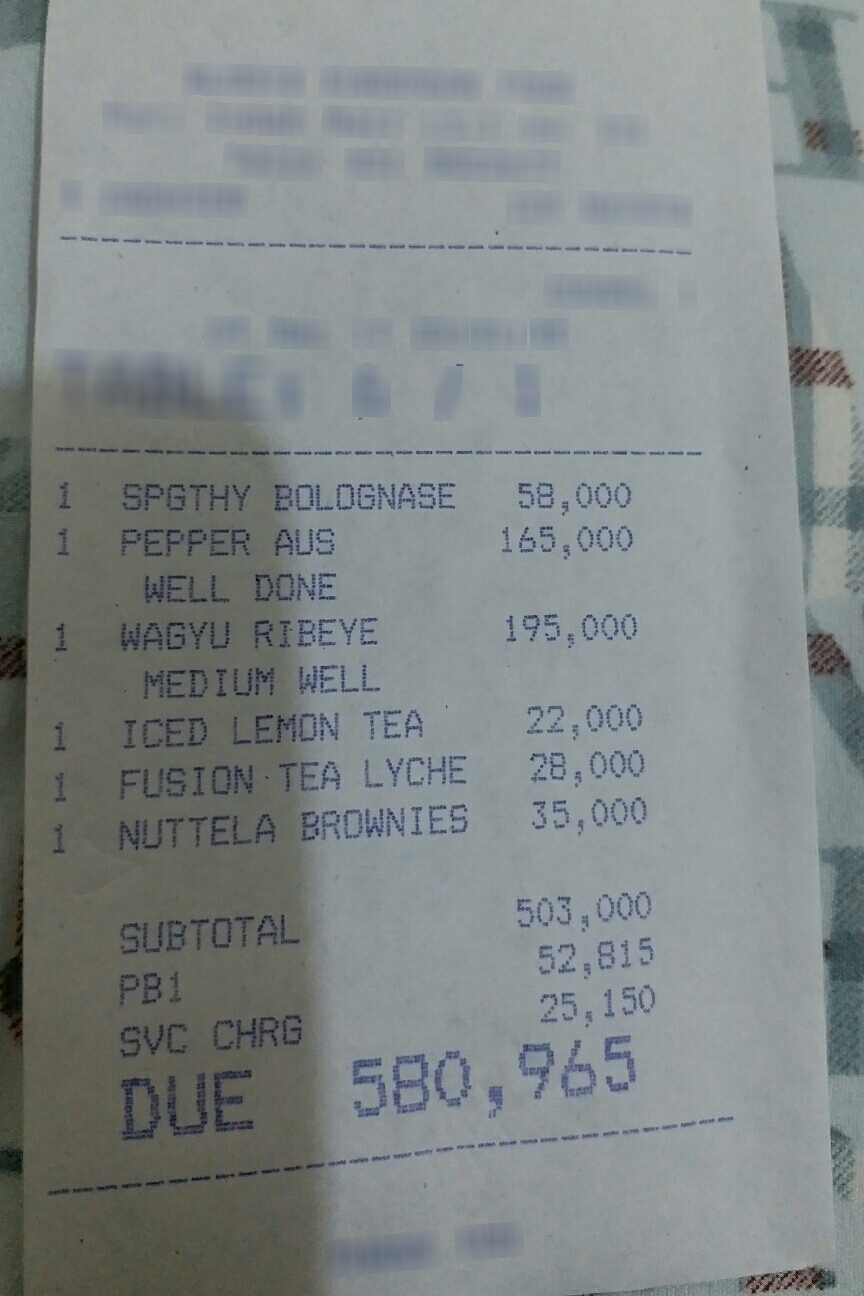

In [28]:
from PIL import Image
Image.open(os.path.join("datasets/cord-ocr/train/", f"{1}.png"))

In [2]:
from data.cord_ocr import CORDOCRDataset
from data.ocr import SynthdogDataset
from transformers import (
    DonutProcessor,
    VisionEncoderDecoderConfig,
    VisionEncoderDecoderModel,
)
from config import settings
from donut import DonutModel

config = VisionEncoderDecoderConfig.from_pretrained(settings.base_model)
config.encoder.image_size = settings.image_size
config.decoder.max_length = settings.max_length

model = DonutModel.from_encoder_decoder_pretrained(
    encoder_pretrained_model_name_or_path="microsoft/swin-base-patch4-window12-384",
    decoder_pretrained_model_name_or_path="hyunwoongko/asian-bart-ecjk",
    base_config=config,
)

processor = DonutProcessor.from_pretrained(settings.base_model)
processor.image_processor.size = settings.image_size[
    ::-1
]  # should be (width, height)

Some weights of the model checkpoint at microsoft/swin-base-patch4-window12-384 were not used when initializing SwinModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing SwinModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing SwinModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at hyunwoongko/asian-bart-ecjk were not used when initializing MBartForCausalLM: ['model.encoder.layers.2.fc1.weight', 'model.encoder.layers.10.final_layer_norm.bias', 'model.encoder.layers.11.self_attn.out_proj.bias', 'model.encoder.layers.11.self_attn.q_proj.bias', 'model.encoder.layers.9.self_attn.k_proj.bias', 'model.encoder.layers.10.self_

In [8]:
train_cord_dataset = CORDOCRDataset(
        model=model,
        processor=processor,
        dataset_name_or_path="datasets/cord-ocr/train/",
        max_length=settings.max_length,
        split="train",
        task_start_token=settings.task_start_token,
        prompt_end_token=settings.prompt_end_token,
    )

train_synthdog_dataset = SynthdogDataset(
        model=model,
        processor=processor,
        dataset_name_or_path=settings.dataset_name,
        max_length=settings.max_length,
        split="train",
        task_start_token=settings.task_start_token,
        prompt_end_token=settings.prompt_end_token,
        sample_size=500
    )

Found cached dataset parquet (/home/ducviet00/.cache/huggingface/datasets/naver-clova-ix___parquet/naver-clova-ix--synthdog-ja-be4034de659b76d6/0.0.0/14a00e99c0d15a23649d0db8944380ac81082d4b021f398733dd84f3a6c569a7)


In [4]:
train_cord_dataset[0]

(tensor([[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]],
 
         [[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]],
 
         [[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]]),
 tensor([37046, 52367, 57225,  ...,  -100,  -100,  -100]),
 'YANG YUM GUI MOKDENGS

In [11]:
from torch.utils.data import ConcatDataset

train_dataset = ConcatDataset([train_cord_dataset, train_synthdog_dataset])

In [13]:
len(train_dataset)

1300